In [1]:
import numpy as np
import pandas as pd
import sys, codecs
import dask.dataframe as dd
import dask.array as da
import dask.bag as db
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.cluster import KMeans
import math
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso
from gensim.models.phrases import Phrases,Phraser
from gensim.models import Word2Vec
from nltk.stem import WordNetLemmatizer
import ast
import os    
import glob
import datetime
import umap
import geopandas as gpd
from mgwr.gwr import GWR, MGWR
from mgwr.sel_bw import Sel_BW
from mgwr.utils import shift_colormap, truncate_colormap
from textblob import TextBlob

/opt/conda/envs/sds2021/lib/python3.9/site-packages/spglm/utils.py:367: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if resetlist is not ():


In [2]:
train_x=pd.read_csv('train_x50000_lond.csv')
train_y=pd.read_csv('train_y50000_lond.csv')
train_x_g=pd.read_csv('train_x_g50000_lond.csv')

In [4]:
# gwr input
# train_x=pd.read_csv('train_x.csv')[0:30000]
# train_y=pd.read_csv('train_y.csv')[0:30000]
# train_x_g=pd.read_csv('train_x_g.csv')[0:30000]
train_cor=list(zip(train_x_g['lon'],train_x_g['lat']))
# test_cor=list(zip(test_x['lon'],test_x['lat']))
train_x_g1=train_x.values
# test_x_g=test_x[gwr_var].values
train_y_g1 =train_y.values.reshape((-1,1))
# test_y_g =test_y.values.reshape((-1,1))
# train_cor1=train_cor[0:5000]
# train_y_g1=train_y_g[0:5000]
# train_x_g1=train_x_g[0:5000]

In [5]:
%%time
# london 20000 116
gwr_selector = Sel_BW(train_cor[0:20000], train_y_g1[0:20000], train_x_g1[0:20000])
gwr_bw = gwr_selector.search()
print('1')
gwr_results = GWR(train_cor[0:20000], train_y_g1[0:20000], train_x_g1[0:20000],gwr_bw).fit()

1
CPU times: user 1h 49min 35s, sys: 4h 29min 26s, total: 6h 19min 2s
Wall time: 23min 43s


In [4]:
%%time
# london 20000 116
gwr_selector = Sel_BW(train_cor, train_y_g1, train_x_g1)
gwr_bw = gwr_selector.search()
print('1')
gwr_results = GWR(train_cor, train_y_g1, train_x_g1,gwr_bw).fit()

1
CPU times: user 13h 48min 2s, sys: 1d 13h 40min 25s, total: 2d 3h 28min 28s
Wall time: 3h 13min 18s


In [6]:
gwr_results.summary()

Model type                                                         Gaussian
Number of observations:                                               20000
Number of covariates:                                                    12

Global Regression Results
---------------------------------------------------------------------------
Residual sum of squares:                                       15962079278802264.000
Log-likelihood:                                                 -302433.818
AIC:                                                             604891.635
AICc:                                                            604893.654
BIC:                                                           15962079278604314.000
R2:                                                                   0.275
Adj. R2:                                                              0.275

Variable                              Est.         SE  t(Est/SE)    p-value
------------------------------- ----------

In [14]:
gwr_results

In [6]:
# 回归参数
var_names=['sentiment_polarity','sentiment_subjectivity']
gwr_coefficent=pd.DataFrame(gwr_results.params[:,4:6],columns=var_names)
# 回归参数显著性
# gwr_flter_t=pd.DataFrame(gwr_results.filter_tvals())
# 将点数据回归结果放到面上展示
# 主要是由于两个文件中的记录数不同，矢量面中的记录比csv中多几条，因此需要将没有参加gwr的区域去掉

georgia_data_geo=gpd.GeoDataFrame(gwr_coefficent,geometry=gpd.points_from_xy(train_x_g[0:50000].lon, train_x_g[0:50000].lat, crs='epsg:4326'))
georgia_data_geo=georgia_data_geo.to_crs("epsg:27700")
# 将回归参数与面数据结合
# georgia_shp_geo=gp.sjoin(georgia_shp,georgia_data_geo, how="inner", op='intersects').reset_index()

In [147]:
georgia_data_geo.to_csv('georgia_data_geo_ldn.csv')

In [145]:
georgia_data_geo1=pd.read_csv('georgia_data_geo_ldn.csv')
georgia_data_geo=gpd.GeoDataFrame(georgia_data_geo1[['sentiment_polarity','sentiment_subjectivity']],geometry=gpd.points_from_xy(train_x_g[0:50000].lon, train_x_g[0:50000].lat, crs='epsg:4326'))
georgia_data_geo=georgia_data_geo.to_crs("epsg:27700")

In [142]:
georgia_data_geo[['sentiment_polarity','sentiment_subjectivity']].describe()

sentiment_polarity  sentiment_subjectivity
count        5.000000e+04            5.000000e+04
mean         3.621034e+04           -1.231646e+05
std          2.148265e+05            1.035815e+06
min         -1.942701e+06           -3.602834e+07
25%         -1.084055e+04           -2.570055e+05
50%          2.408852e+04           -6.975864e+03
75%          6.930686e+04            1.726006e+05
max          3.101028e+06            1.028031e+07

In [58]:
gwr_f1=pd.DataFrame(gwr_results.filter_tvals())

georgia_data_geo_f1=georgia_data_geo.iloc[gwr_f1[gwr_f1[4]!=0].index.tolist()]
georgia_data_geo_f1['lon']=train_x_g[0:50000].lon
georgia_data_geo_f1['lat']=train_x_g[0:50000].lat

/opt/conda/envs/sds2021/lib/python3.9/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


In [59]:
gwr_f2=pd.DataFrame(gwr_results.filter_tvals())

georgia_data_geo_f2=georgia_data_geo.iloc[gwr_f1[gwr_f1[5]!=0].index.tolist()]
georgia_data_geo_f2['lon']=train_x_g[0:50000].lon
georgia_data_geo_f2['lat']=train_x_g[0:50000].lat

tmp1

In [ ]:
georgia_data_geo

In [49]:
tmp=georgia_data_geo[georgia_data_geo['sentiment_polarity']>0.5e+06]
tmp1=georgia_data_geo[georgia_data_geo['sentiment_polarity']<-0.5e+06]
tmp1=pd.concat([tmp,tmp1],axis=0)
tmp1['lon']=train_x_g[0:50000].lon
tmp1['lat']=train_x_g[0:50000].lat

In [50]:
tmp1.shape

(2013, 5)

In [23]:
georgia_data_geo['sentiment_subjectivity'].describe()

count    5.000000e+04
mean    -1.231646e+05
std      1.035815e+06
min     -3.602834e+07
25%     -2.570055e+05
50%     -6.975864e+03
75%      1.726006e+05
max      1.028031e+07
Name: sentiment_subjectivity, dtype: float64

In [137]:
georgia_data_geo[['sentiment_polarity','sentiment_subjectivity']]

sentiment_polarity  sentiment_subjectivity
0            12306.022592           -7.047033e+04
1            81797.261220           -7.971672e+04
2            17407.357806           -1.392840e+06
3          -260956.318002           -1.997311e+05
4           -52321.307973           -3.505717e+05
...                   ...                     ...
49995        39549.513918            3.120506e+05
49996       610664.436393           -1.484882e+05
49997       367833.888143            7.517298e+05
49998        44178.558220           -2.448922e+05
49999      -293167.472784           -6.523680e+05

[50000 rows x 2 columns]

<AxesSubplot:ylabel='sentiment_subjectivity'>

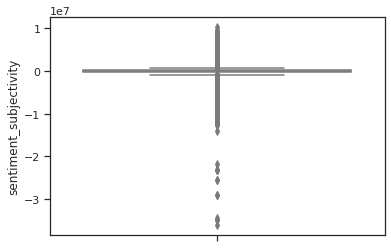

In [21]:
import seaborn as sns
# sns.set_style('whitegrid')
# sns.set_theme(style="ticks", palette="pastel")
# f,ax = plt.subplots(figsize=(8,5))
# sns.boxplot(y=georgia_data_geo['sentiment_polarity'], x=georgia_data_geo[['sentiment_polarity','sentiment_subjectivity']].index)
sns.boxplot(y=georgia_data_geo['sentiment_subjectivity'])
# sns.despine(offset=10)
# ax.set_ylim([0,500])

tmp12 produce

In [167]:
tmp=georgia_data_geo[georgia_data_geo['sentiment_subjectivity']>2000000]
tmp1=georgia_data_geo[georgia_data_geo['sentiment_subjectivity']<-2000000]
tmp2=pd.concat([tmp,tmp1],axis=0)
tmp2
tmp2['lon']=train_x_g[0:50000].lon
tmp2['lat']=train_x_g[0:50000].lat

In [158]:
georgia_data_geo['sentiment_subjectivity'].describe()

count    5.000000e+04
mean    -1.231646e+05
std      1.035815e+06
min     -3.602834e+07
25%     -2.570055e+05
50%     -6.975864e+03
75%      1.726006e+05
max      1.028031e+07
Name: sentiment_subjectivity, dtype: float64

In [172]:
borough=gpd.read_file('London_Boroughs.gpkg')

/opt/conda/envs/sds2021/lib/python3.9/site-packages/geopandas/geodataframe.py:577: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


In [173]:
msoas = gpd.read_file('https://github.com/jreades/i2p/blob/master/data/src/Middle_Layer_Super_Output_Areas__December_2011__EW_BGC_V2-shp.zip?raw=true')
gdf = gpd.read_file('shapefile/Major_Towns_and_Cities_(December_2015)_Boundaries_V2.geojson')
ldn=gpd.read_file('London_Boroughs.gpkg')
ldn=ldn.to_crs("epsg:27700")
ldn['geometry'] = ldn['geometry'].buffer(500)
ldn = ldn.set_geometry('geometry')
ldn_msoas = gpd.sjoin(msoas, ldn,op='within')

In [174]:
ldn_msoas.drop(['index_right','objectid','gss_code','hectares','nonld_area','ons_inner','sub_2011'],axis=1,inplace=True)

In [175]:
ldn_msoas_join=gpd.sjoin(ldn_msoas,georgia_data_geo)
msoagrdf = ldn_msoas_join.groupby('MSOA11NM').agg({'sentiment_polarity':['mean'],'sentiment_subjectivity':['mean']}).reset_index()
msoagrdf.columns=['MSOA11NM','sentiment_polarity_mean','sentiment_subjectivity_mean']
ldn_msoas_mean=pd.merge(ldn_msoas,msoagrdf,on='MSOA11NM')

In [132]:
ldn_msoas_mean[['sentiment_polarity_mean']].describe()

sentiment_polarity_mean
count               989.000000
mean              26714.474035
std              112753.037884
min             -752699.785604
25%               -3324.764165
50%               21332.740933
75%               50369.241286
max              717768.690856

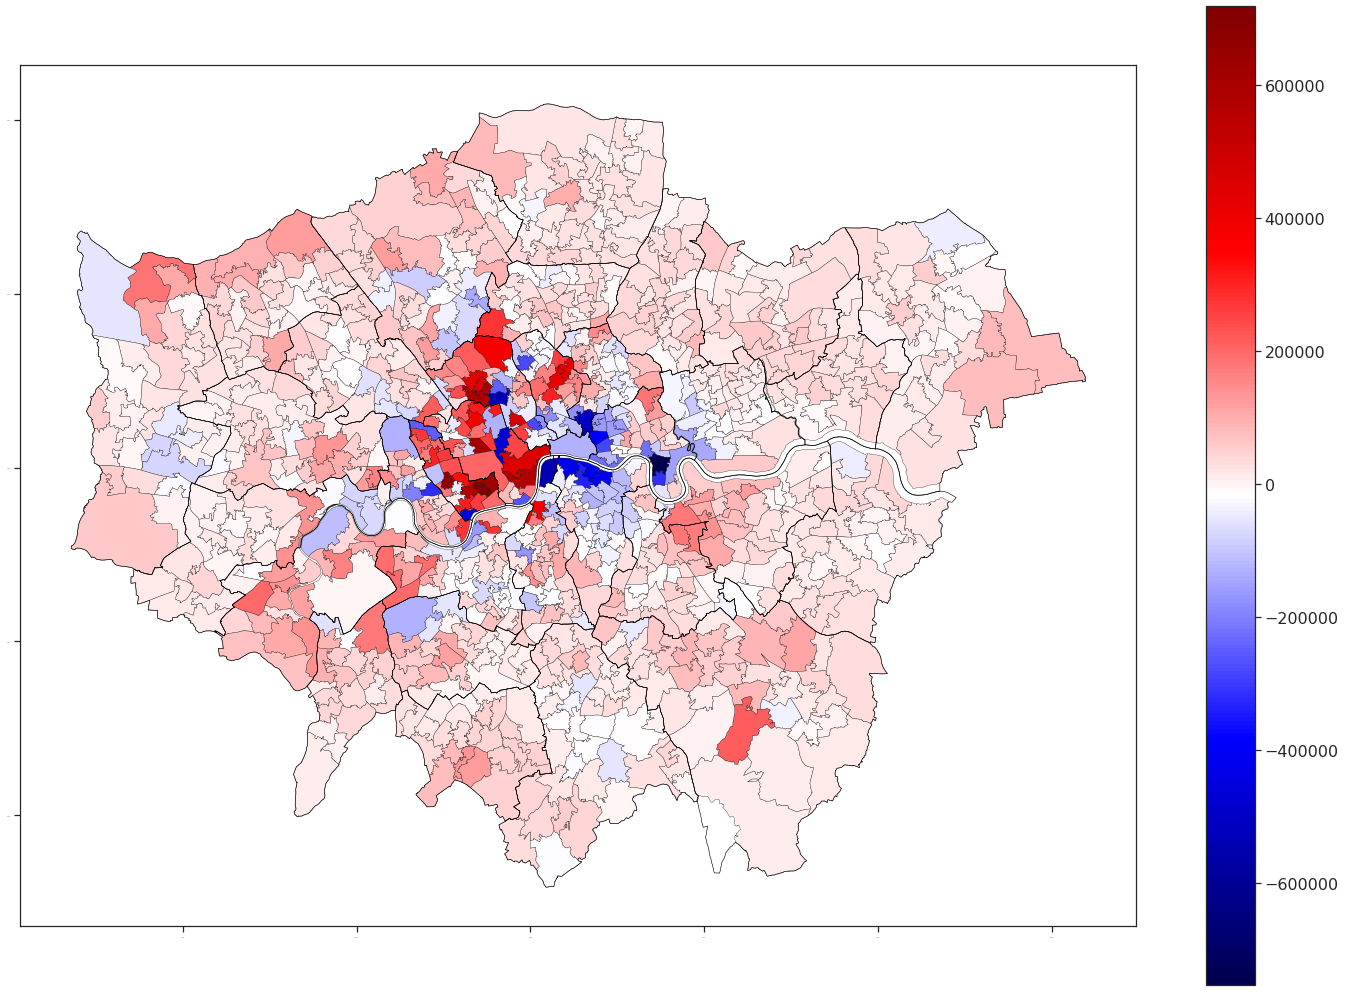

In [181]:
import matplotlib.pyplot as plt
import matplotlib.colors as colors
vmin=ldn_msoas_mean.sentiment_polarity_mean.min()
vmax=ldn_msoas_mean.sentiment_polarity_mean.max()
f,ax = plt.subplots(figsize=(25,18))
cmap = plt.cm.seismic
sm = plt.cm.ScalarMappable(cmap=cmap,norm = plt . Normalize (vmin = vmin , vmax = vmax ))

cmap=sm.cmap 
# vmin=georgia_data_geo.sentiment_polarity.min()
# vmax=georgia_data_geo.sentiment_polarity.max()
# vmin1=ldn_msoas_mean.sentiment_polarity_mean.min()
# vmax1=ldn_msoas_mean.sentiment_polarity_mean.max()
# cmap = shift_colormap(cmap,start=0.0, midpoint=0.999- vmax1/(vmax1 + abs(vmin1)))
# sm = plt.cm.ScalarMappable(cmap=cmap,norm = plt . Normalize (vmin = vmin , vmax = vmax ))
# sm1 = plt.cm.ScalarMappable(cmap=cmap,norm = plt . Normalize (vmin = vmin1 , vmax = vmax1 ))
# gdf[gdf['TCITY15NM']=='London'].plot(facecolor='none',ax=ax)


ldn_msoas_mean.plot( column='sentiment_polarity_mean' ,cmap=cmap, edgecolor='black', lw=0.3,
          ax=ax)
borough.plot(facecolor='none',ax=ax,edgecolor='black', lw=0.6)
cbar = f.colorbar(sm)
cbar.ax.tick_params(labelsize=16)
plt.xticks(fontsize=0)
plt.yticks(fontsize=0)
plt.savefig('po1.png')
# borough.plot(column='name',ax=ax,edgecolor='black')

/opt/conda/envs/sds2021/lib/python3.9/site-packages/mgwr/utils.py:56: UserWarning: Trying to register the cmap 'shiftedcmap' which already exists.
  plt.register_cmap(cmap=new_cmap)


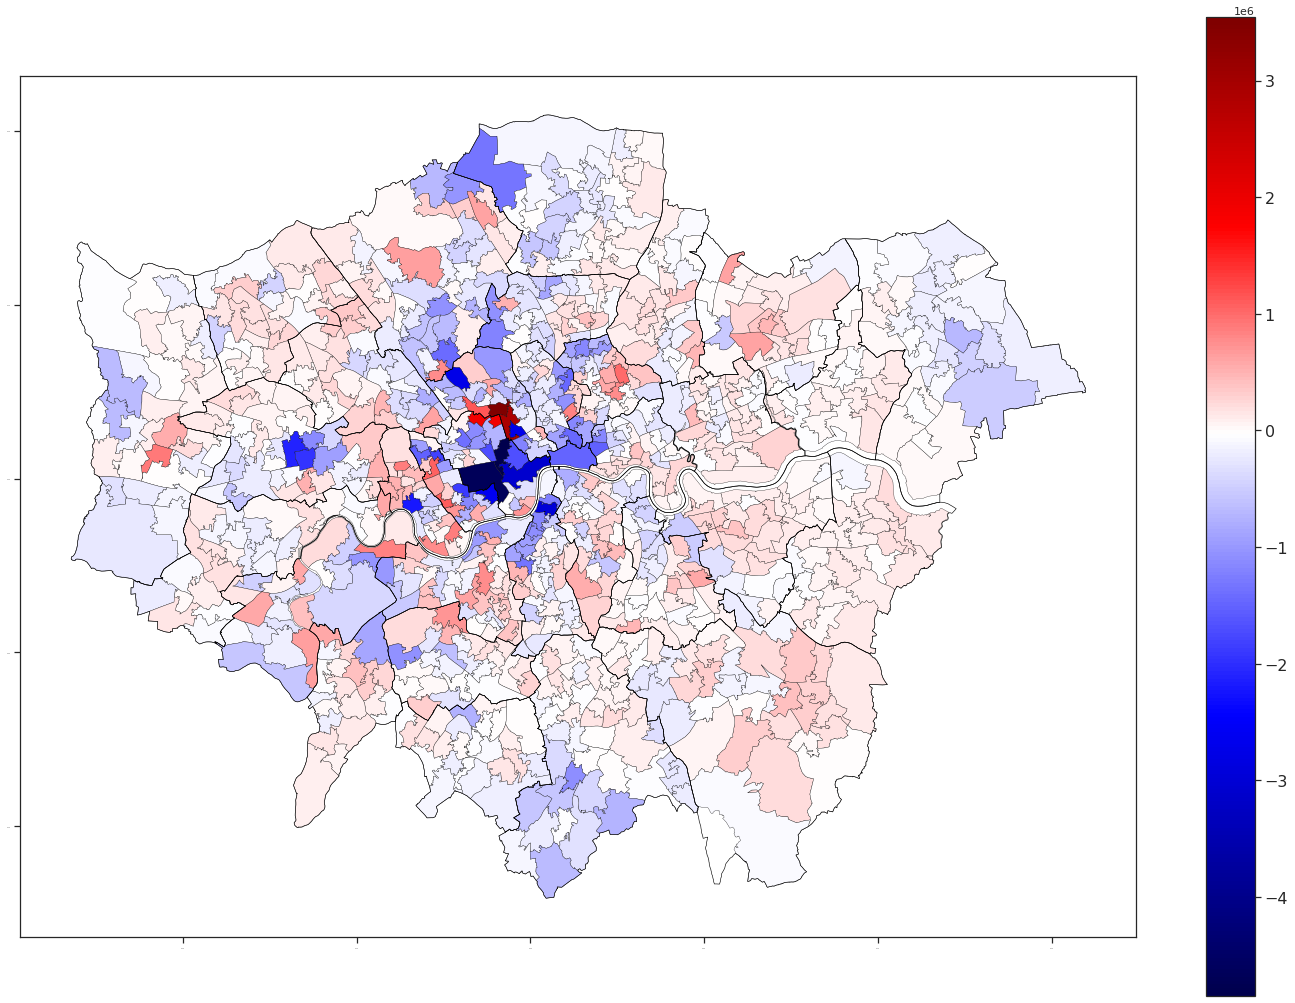

In [186]:
import matplotlib.pyplot as plt
import matplotlib.colors as colors

f,ax = plt.subplots(figsize=(25,18))
cmap = plt.cm.seismic
vmin1=ldn_msoas_mean.sentiment_subjectivity_mean.min()
vmax1=ldn_msoas_mean.sentiment_subjectivity_mean.max()
cmap = shift_colormap(cmap,start=0.0, midpoint=0.999- vmax1/(vmax1 + abs(vmin1)))
sm = plt.cm.ScalarMappable(cmap=cmap,norm = plt . Normalize (vmin = vmin , vmax = vmax ))
# vmin=georgia_data_geo_clu.sentiment_subjectivity.min()
# vmax=georgia_data_geo_clu.sentiment_subjectivity.max()
# vmin=georgia_data_geo.sentiment_polarity.min()
# vmax=georgia_data_geo.sentiment_polarity.max()


# sm = plt.cm.ScalarMappable(cmap=cmap,norm = plt . Normalize (vmin = vmin , vmax = vmax ))
# sm1 = plt.cm.ScalarMappable(cmap=cmap,norm = plt . Normalize (vmin = vmin1 , vmax = vmax1 ))
# gdf[gdf['TCITY15NM']=='London'].plot(facecolor='none',ax=ax)


ldn_msoas_mean.plot( column='sentiment_subjectivity_mean' ,cmap=cmap, edgecolor='black', lw=0.3,
          ax=ax)
borough.plot(facecolor='none',ax=ax,edgecolor='black', lw=0.6)
# borough.plot(column='name',ax=ax,edgecolor='black')
cbar = f.colorbar(sm)
cbar.ax.tick_params(labelsize=16)
plt.xticks(fontsize=0)
plt.yticks(fontsize=0)
plt.savefig('sub1.png')

georgia_data_geo_f1

In [200]:
from sklearn.preprocessing import RobustScaler, MinMaxScaler
df_clu=georgia_data_geo_f1

rs = RobustScaler(quantile_range=(10.0, 90.0))
raw = df_clu[['sentiment_polarity','lon','lat','sentiment_subjectivity']].copy()
normed = raw.copy()
for c in raw.columns.values:
    normed[c] = rs.fit_transform(raw[c].values.reshape(-1,1))
    print("The range of {} is [{}, {}]".format(c, normed[c].min(), normed[c].max()))
normed.head()
from sklearn.cluster import KMeans, DBSCAN
minPts = 5 # we set minPts as normed.shape[1] + 1 
epsilon = 0.2
dbsc = DBSCAN(eps=epsilon, min_samples=minPts)
dbsc.fit(normed)
cluster_nm = dbsc.labels_
df_clu['clu']=cluster_nm

The range of sentiment_polarity is [-1.2516540144465493, 1.2979952912199924]
The range of lon is [-2.2369892247104746, 2.250573292988035]
The range of lat is [-1.333446164714222, 1.3695031494672099]
The range of sentiment_subjectivity is [-5.282385485051828, 1.6276309478745838]


/opt/conda/envs/sds2021/lib/python3.9/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


In [66]:
df_clu

sentiment_polarity  sentiment_subjectivity  \
16          -6.640877e+05           -3.640191e+06   
23           1.221074e+06            1.578768e+06   
32           6.865018e+05            3.129547e+06   
40           5.494918e+05           -8.964651e+05   
60           2.956036e+05            2.193703e+06   
...                   ...                     ...   
49960       -9.437817e+05           -7.684869e+06   
49981       -8.281275e+05            5.475472e+06   
49990       -1.240920e+06            1.099435e+06   
49993        4.325123e+05           -5.282240e+05   
49996        6.106644e+05           -1.484882e+05   

                            geometry       lon        lat  clu  
16     POINT (528767.771 181608.297) -0.145511  51.518726    0  
23     POINT (525266.998 179269.867) -0.196769  51.498497    1  
32     POINT (524604.021 178989.087) -0.206414  51.496120    2  
40     POINT (525192.673 181331.351) -0.197108  51.517040    2  
60     POINT (521296.463 169943.200) -0.257136  51.415540    3  
...                              ...       ...        ...  ...  
49960  POINT (528610.727 181594.972) -0.147778  51.518642    0  
49981  POINT (528709.747 183878.404) -0.145518  51.539140    8  
49990  POINT (525680.650 179115.392) -0.190868  51.497017   16  
49993  POINT (527281.013 181401.033) -0.167002  51.517200    5  
49996  POINT (516771.573 173421.830) -0.321028  51.447754   -1  

[2075 rows x 6 columns]

In [201]:
georgia_data_geo_clu=df_clu
georgia_data_geo_clu.groupby('clu').count()

sentiment_polarity  sentiment_subjectivity  geometry  lon  lat
clu                                                                
-1                  127                     127       127  127  127
 0                  110                     110       110  110  110
 1                   11                      11        11   11   11
 2                  898                     898       898  898  898
 3                    6                       6         6    6    6
 4                   20                      20        20   20   20
 5                  379                     379       379  379  379
 6                   19                      19        19   19   19
 7                   65                      65        65   65   65
 8                   33                      33        33   33   33
 9                   41                      41        41   41   41
 10                  23                      23        23   23   23
 11                  44                      44        44   44   44
 12                  12                      12        12   12   12
 13                  42                      42        42   42   42
 14                   8                       8         8    8    8
 15                   7                       7         7    7    7
 16                  20                      20        20   20   20
 17                  11                      11        11   11   11
 18                  28                      28        28   28   28
 19                  15                      15        15   15   15
 20                  25                      25        25   25   25
 21                   7                       7         7    7    7
 22                   8                       8         8    8    8
 23                   8                       8         8    8    8
 24                  21                      21        21   21   21
 25                   7                       7         7    7    7
 26                   6                       6         6    6    6
 27                   7                       7         7    7    7
 28                   8                       8         8    8    8
 29                   8                       8         8    8    8
 30                   7                       7         7    7    7
 31                   6                       6         6    6    6
 32                   5                       5         5    5    5
 33                   6                       6         6    6    6
 34                   8                       8         8    8    8
 35                   7                       7         7    7    7
 36                   5                       5         5    5    5
 37                   7                       7         7    7    7

NameError: name 'georgia_data_geo_clu' is not defined

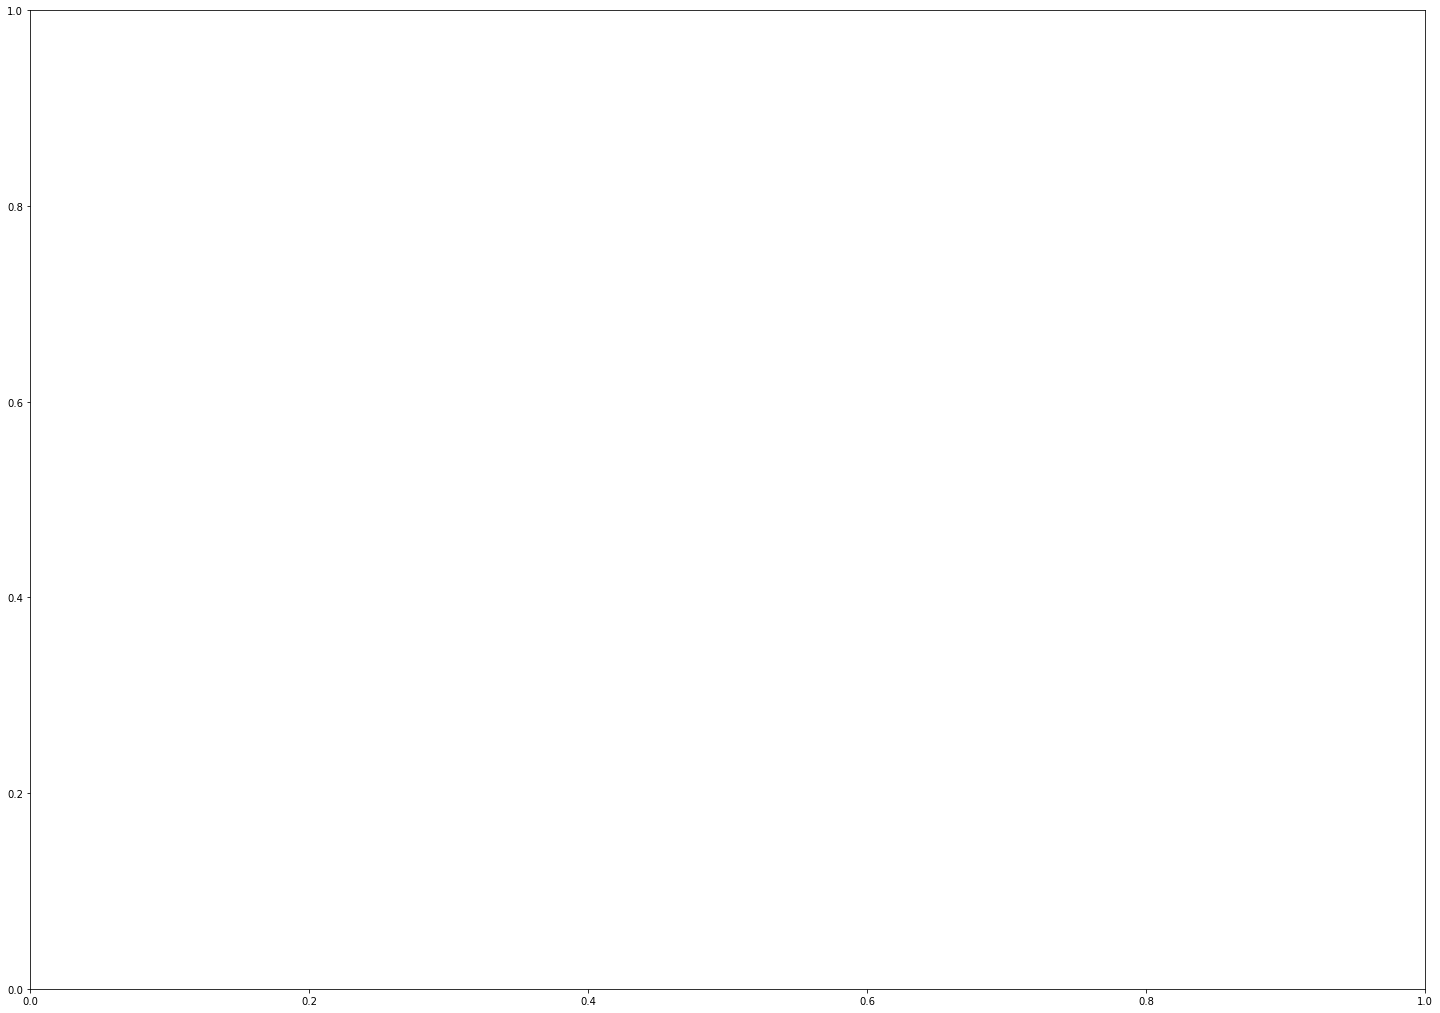

In [13]:
import matplotlib.pyplot as plt
f,ax = plt.subplots(figsize=(25,18))
cmap = plt.cm.seismic

vmin=georgia_data_geo_clu.sentiment_polarity.min()
vmax=georgia_data_geo_clu.sentiment_polarity.max()

# vmin1=ldn_msoas_mean.sentiment_polarity_mean.min()
# vmax1=ldn_msoas_mean.sentiment_polarity_mean.max()
cmap = shift_colormap(cmap,start=0.0, midpoint=1- vmax/(vmax + abs(vmin)))
# vmin=-vmax
sm = plt.cm.ScalarMappable(cmap=cmap,norm = plt . Normalize (vmin = vmin , vmax = vmax ))
sm1 = plt.cm.ScalarMappable(cmap=cmap,norm = plt . Normalize (vmin = -vmax , vmax = vmax ))
cmap=sm.cmap   
# sm1 = plt.cm.ScalarMappable(cmap=cmap,norm = plt . Normalize (vmin = vmin1 , vmax = vmax1 ))
# gdf[gdf['TCITY15NM']=='London'].plot(facecolor='none',ax=ax)
ldn_msoas.plot(facecolor='none',color='lightgrey',ax=ax,edgecolor='black',lw=0.3)
# georgia_shp_geo.plot(column='cof_apartment',cmap='viridis', legend=True, marker='*', markersize=1, ax=ax)
# georgia_data_geo_clu.plot( column='sentiment_polarity',marker='*', markersize=5,cmap=cmap,vmin=vmin,vmax=vmax, ax=ax)
# georgia_data_geo_clu[georgia_data_geo_clu['clu']==0].plot( column='sentiment_polarity',marker='s', markersize=20,cmap=cmap, 
#         vmin=vmin,vmax=vmax,ax=ax)
borough.plot(facecolor='none',ax=ax,edgecolor='black', lw=0.6)
georgia_data_geo_clu[georgia_data_geo_clu['clu']==0].plot( column='sentiment_polarity',marker='^',markersize=20,cmap=cmap, edgecolor='black',
         vmin=vmin,vmax=vmax,ax=ax,lw=0.6)
georgia_data_geo_clu[georgia_data_geo_clu['clu']==2].plot( column='sentiment_polarity',marker='s', markersize=20,cmap=cmap, edgecolor='black',
          vmin=vmin,vmax=vmax,ax=ax,lw=0.6)
georgia_data_geo_clu[georgia_data_geo_clu['clu']==5].plot( column='sentiment_polarity', markersize=20,cmap=cmap, edgecolor='black',
          vmin=vmin,vmax=vmax,ax=ax,lw=0.6)
# georgia_data_geo_clu[georgia_data_geo_clu['clu']==12].plot( column='sentiment_polarity',marker='>', markersize=20,cmap=cmap, edgecolor='black',
#           vmin=vmin,vmax=vmax,ax=ax)
plt.legend((georgia_data_geo_clu[georgia_data_geo_clu['clu']==0]),loc="center left")
cbar = f.colorbar(sm)
# ax.set_xlim([520000,535000])
# ax.set_ylim([175000,186000])

/opt/conda/envs/sds2021/lib/python3.9/site-packages/mgwr/utils.py:56: UserWarning: Trying to register the cmap 'shiftedcmap' which already exists.
  plt.register_cmap(cmap=new_cmap)


(175000.0, 186000.0)

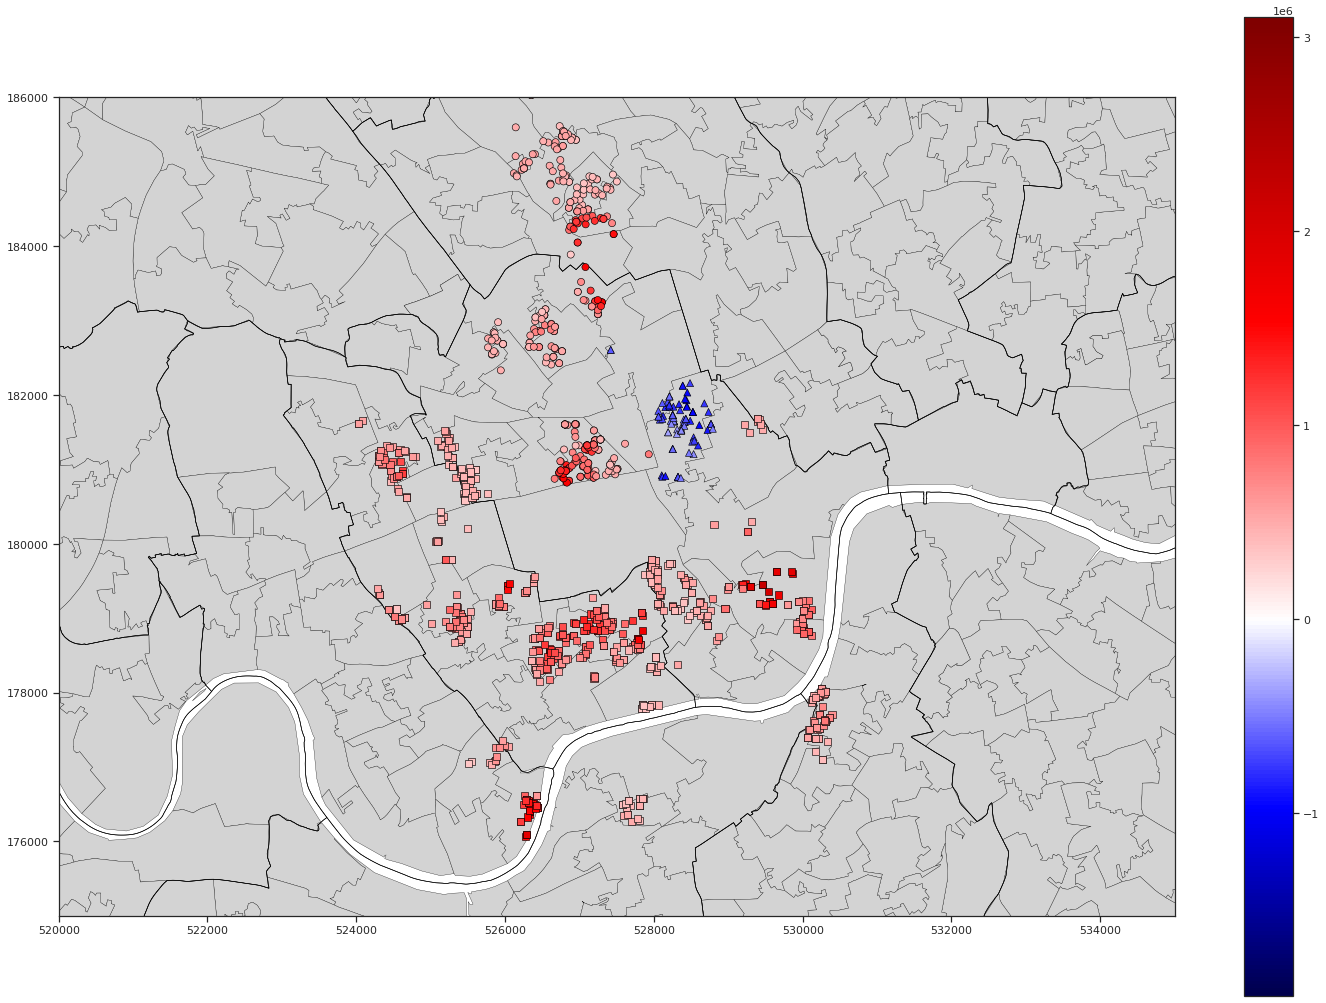

In [205]:
import matplotlib.pyplot as plt
f,ax = plt.subplots(figsize=(25,18))
cmap = plt.cm.seismic

vmin=georgia_data_geo_clu.sentiment_polarity.min()
vmax=georgia_data_geo_clu.sentiment_polarity.max()

# vmin1=ldn_msoas_mean.sentiment_polarity_mean.min()
# vmax1=ldn_msoas_mean.sentiment_polarity_mean.max()
cmap = shift_colormap(cmap,start=0.0, midpoint=1- vmax/(vmax + abs(vmin)))
# vmin=-vmax
sm = plt.cm.ScalarMappable(cmap=cmap,norm = plt . Normalize (vmin = vmin , vmax = vmax ))
sm1 = plt.cm.ScalarMappable(cmap=cmap,norm = plt . Normalize (vmin = -vmax , vmax = vmax ))
cmap=sm.cmap   
# sm1 = plt.cm.ScalarMappable(cmap=cmap,norm = plt . Normalize (vmin = vmin1 , vmax = vmax1 ))
# gdf[gdf['TCITY15NM']=='London'].plot(facecolor='none',ax=ax)
ldn_msoas.plot(facecolor='none',color='lightgrey',ax=ax,edgecolor='black',lw=0.3)
# georgia_shp_geo.plot(column='cof_apartment',cmap='viridis', legend=True, marker='*', markersize=1, ax=ax)
# georgia_data_geo_clu.plot( column='sentiment_polarity',marker='*', markersize=20,cmap=cmap,vmin=vmin,vmax=vmax, ax=ax)
# georgia_data_geo_clu[georgia_data_geo_clu['clu']==0].plot( column='sentiment_polarity',marker='s', markersize=20,cmap=cmap, 
#         vmin=vmin,vmax=vmax,ax=ax)
borough.plot(facecolor='none',ax=ax,edgecolor='black', lw=0.6)
georgia_data_geo_clu[georgia_data_geo_clu['clu']==0].plot( column='sentiment_polarity',marker='^',markersize=50,cmap=cmap, edgecolor='black',
         vmin=vmin,vmax=vmax,ax=ax,lw=0.6)
georgia_data_geo_clu[georgia_data_geo_clu['clu']==2].plot( column='sentiment_polarity',marker='s', markersize=50,cmap=cmap, edgecolor='black',
          vmin=vmin,vmax=vmax,ax=ax,lw=0.6)
georgia_data_geo_clu[georgia_data_geo_clu['clu']==5].plot( column='sentiment_polarity', markersize=50,cmap=cmap, edgecolor='black',
          vmin=vmin,vmax=vmax,ax=ax,lw=0.6)
# georgia_data_geo_clu[georgia_data_geo_clu['clu']==12].plot( column='sentiment_polarity',marker='>', markersize=20,cmap=cmap, edgecolor='black',
#           vmin=vmin,vmax=vmax,ax=ax)

cbar = f.colorbar(sm)
ax.set_xlim([520000,535000])
ax.set_ylim([175000,186000])

In [90]:
from sklearn.preprocessing import RobustScaler, MinMaxScaler
df_clu=georgia_data_geo_f2

rs = RobustScaler(quantile_range=(10.0, 90.0))
raw = df_clu[['sentiment_polarity','lon','lat','sentiment_subjectivity']].copy()
normed = raw.copy()
for c in raw.columns.values:
    normed[c] = rs.fit_transform(raw[c].values.reshape(-1,1))
    print("The range of {} is [{}, {}]".format(c, normed[c].min(), normed[c].max()))
normed.head()
from sklearn.cluster import KMeans, DBSCAN
minPts = 5 # we set minPts as normed.shape[1] + 1 
epsilon = 0.2
dbsc = DBSCAN(eps=epsilon, min_samples=minPts)
dbsc.fit(normed)
cluster_nm = dbsc.labels_
df_clu['clu']=cluster_nm

The range of sentiment_polarity is [-1.306798810076509, 1.7875814466858322]
The range of lon is [-2.4902748962655603, 1.4961747925311206]
The range of lat is [-3.294347571964667, 3.3774739012554256]
The range of sentiment_subjectivity is [-2.6979358499568895, 1.1755370708758912]


/opt/conda/envs/sds2021/lib/python3.9/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


In [91]:
georgia_data_geo_clu=df_clu
georgia_data_geo_clu.groupby('clu').count()

sentiment_polarity  sentiment_subjectivity  geometry  lon  lat
clu                                                                
-1                   95                      95        95   95   95
 0                  414                     414       414  414  414
 1                   62                      62        62   62   62
 2                   48                      48        48   48   48
 3                   22                      22        22   22   22
 4                    8                       8         8    8    8
 5                   33                      33        33   33   33
 6                   33                      33        33   33   33
 7                    6                       6         6    6    6
 8                   19                      19        19   19   19
 9                    9                       9         9    9    9
 10                   7                       7         7    7    7
 11                  10                      10        10   10   10
 12                  31                      31        31   31   31
 13                   5                       5         5    5    5
 14                  15                      15        15   15   15
 15                  19                      19        19   19   19
 16                   7                       7         7    7    7
 17                  12                      12        12   12   12
 18                   8                       8         8    8    8
 19                   7                       7         7    7    7
 20                  15                      15        15   15   15
 21                  11                      11        11   11   11
 22                  14                      14        14   14   14
 23                   8                       8         8    8    8
 24                   6                       6         6    6    6
 25                   7                       7         7    7    7
 26                   7                       7         7    7    7
 27                   8                       8         8    8    8
 28                   7                       7         7    7    7
 29                   7                       7         7    7    7
 30                   5                       5         5    5    5
 31                   9                       9         9    9    9
 32                   5                       5         5    5    5

/opt/conda/envs/sds2021/lib/python3.9/site-packages/mgwr/utils.py:56: UserWarning: Trying to register the cmap 'shiftedcmap' which already exists.
  plt.register_cmap(cmap=new_cmap)


(175000.0, 186000.0)

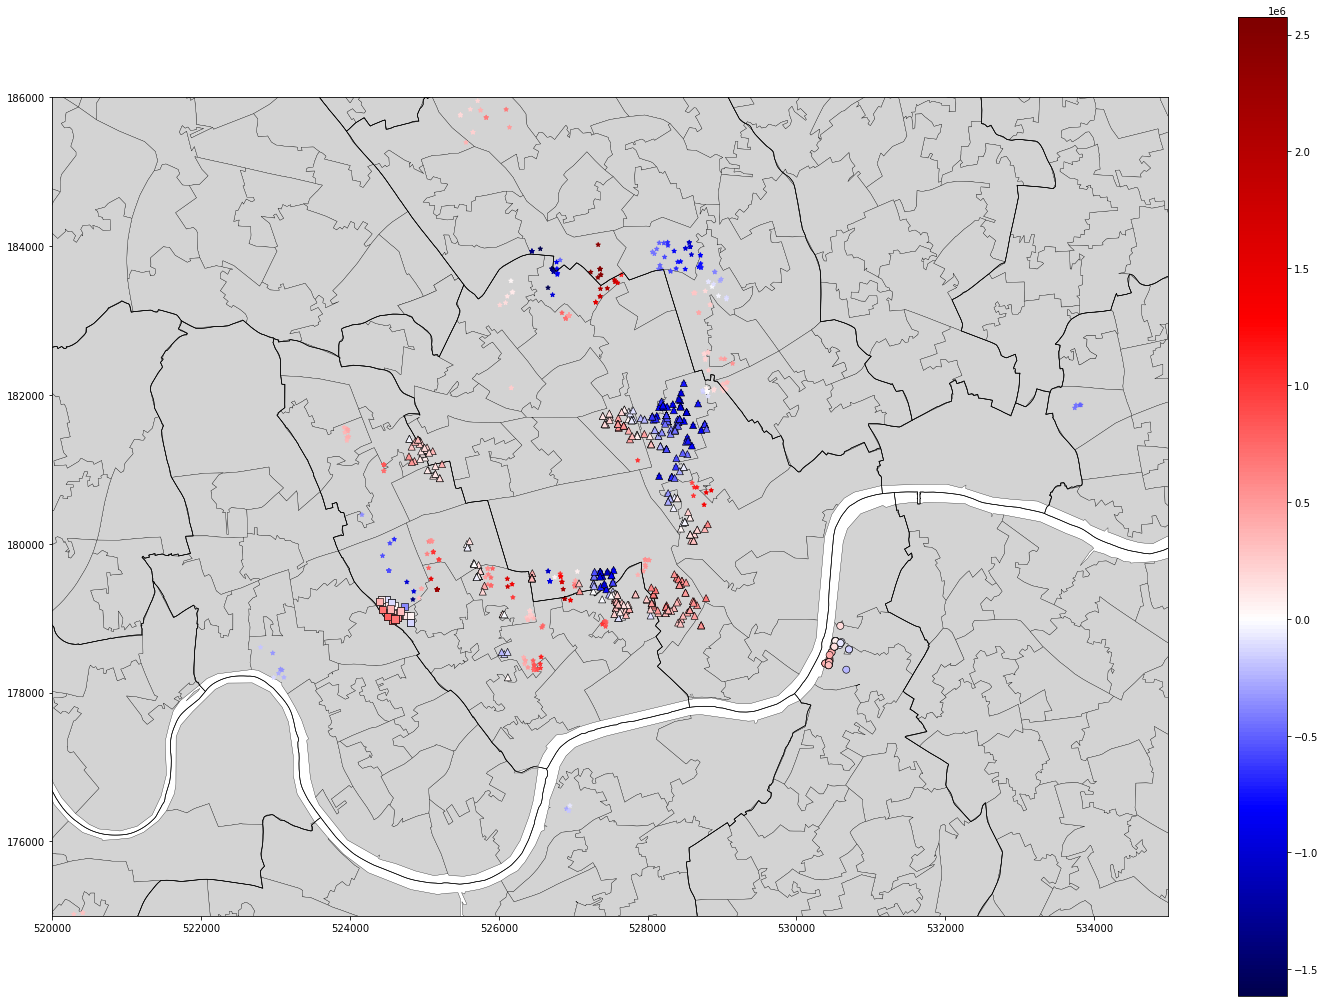

In [92]:
import matplotlib.pyplot as plt
f,ax = plt.subplots(figsize=(25,18))
cmap = plt.cm.seismic

vmin=georgia_data_geo_clu.sentiment_polarity.min()
vmax=georgia_data_geo_clu.sentiment_polarity.max()

# vmin1=ldn_msoas_mean.sentiment_polarity_mean.min()
# vmax1=ldn_msoas_mean.sentiment_polarity_mean.max()
cmap = shift_colormap(cmap,start=0.0, midpoint=1- vmax/(vmax + abs(vmin)))
# vmin=-vmax
sm = plt.cm.ScalarMappable(cmap=cmap,norm = plt . Normalize (vmin = vmin , vmax = vmax ))
sm1 = plt.cm.ScalarMappable(cmap=cmap,norm = plt . Normalize (vmin = -vmax , vmax = vmax ))
cmap=sm.cmap   
# sm1 = plt.cm.ScalarMappable(cmap=cmap,norm = plt . Normalize (vmin = vmin1 , vmax = vmax1 ))
# gdf[gdf['TCITY15NM']=='London'].plot(facecolor='none',ax=ax)
ldn_msoas.plot(facecolor='none',color='lightgrey',ax=ax,edgecolor='black',lw=0.3)
# georgia_shp_geo.plot(column='cof_apartment',cmap='viridis', legend=True, marker='*', markersize=1, ax=ax)
georgia_data_geo_clu.plot( column='sentiment_polarity',marker='*', markersize=20,cmap=cmap,vmin=vmin,vmax=vmax, ax=ax)
# georgia_data_geo_clu[georgia_data_geo_clu['clu']==0].plot( column='sentiment_polarity',marker='s', markersize=20,cmap=cmap, 
#         vmin=vmin,vmax=vmax,ax=ax)
borough.plot(facecolor='none',ax=ax,edgecolor='black', lw=0.6)
georgia_data_geo_clu[georgia_data_geo_clu['clu']==0].plot( column='sentiment_polarity',marker='^',markersize=50,cmap=cmap, edgecolor='black',
         vmin=vmin,vmax=vmax,ax=ax,lw=0.6)
georgia_data_geo_clu[georgia_data_geo_clu['clu']==1].plot( column='sentiment_polarity',marker='s', markersize=50,cmap=cmap, edgecolor='black',
          vmin=vmin,vmax=vmax,ax=ax,lw=0.6)
georgia_data_geo_clu[georgia_data_geo_clu['clu']==2].plot( column='sentiment_polarity', markersize=50,cmap=cmap, edgecolor='black',
          vmin=vmin,vmax=vmax,ax=ax,lw=0.6)
# georgia_data_geo_clu[georgia_data_geo_clu['clu']==12].plot( column='sentiment_polarity',marker='>', markersize=20,cmap=cmap, edgecolor='black',
#           vmin=vmin,vmax=vmax,ax=ax)

cbar = f.colorbar(sm)
ax.set_xlim([520000,535000])
ax.set_ylim([175000,186000])

/opt/conda/envs/sds2021/lib/python3.9/site-packages/mgwr/utils.py:56: UserWarning: Trying to register the cmap 'shiftedcmap' which already exists.
  plt.register_cmap(cmap=new_cmap)


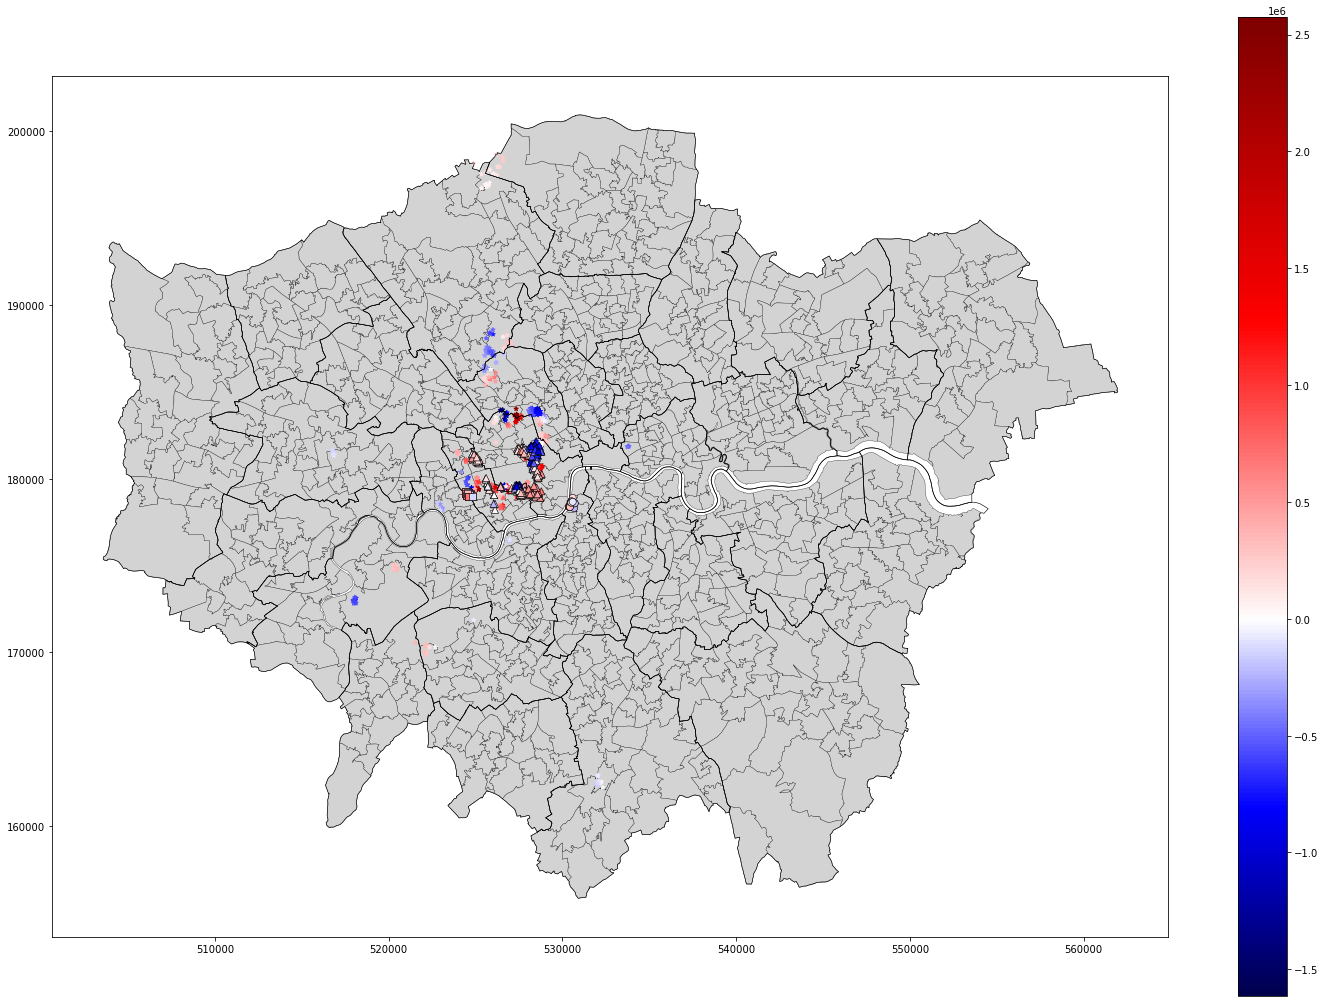

In [93]:
import matplotlib.pyplot as plt
f,ax = plt.subplots(figsize=(25,18))
cmap = plt.cm.seismic

vmin=georgia_data_geo_clu.sentiment_polarity.min()
vmax=georgia_data_geo_clu.sentiment_polarity.max()

# vmin1=ldn_msoas_mean.sentiment_polarity_mean.min()
# vmax1=ldn_msoas_mean.sentiment_polarity_mean.max()
cmap = shift_colormap(cmap,start=0.0, midpoint=1- vmax/(vmax + abs(vmin)))
# vmin=-vmax
sm = plt.cm.ScalarMappable(cmap=cmap,norm = plt . Normalize (vmin = vmin , vmax = vmax ))
sm1 = plt.cm.ScalarMappable(cmap=cmap,norm = plt . Normalize (vmin = -vmax , vmax = vmax ))
cmap=sm.cmap   
# sm1 = plt.cm.ScalarMappable(cmap=cmap,norm = plt . Normalize (vmin = vmin1 , vmax = vmax1 ))
# gdf[gdf['TCITY15NM']=='London'].plot(facecolor='none',ax=ax)
ldn_msoas.plot(facecolor='none',color='lightgrey',ax=ax,edgecolor='black',lw=0.3)
# georgia_shp_geo.plot(column='cof_apartment',cmap='viridis', legend=True, marker='*', markersize=1, ax=ax)
georgia_data_geo_clu.plot( column='sentiment_polarity',marker='*', markersize=20,cmap=cmap,vmin=vmin,vmax=vmax, ax=ax)
# georgia_data_geo_clu[georgia_data_geo_clu['clu']==0].plot( column='sentiment_polarity',marker='s', markersize=20,cmap=cmap, 
#         vmin=vmin,vmax=vmax,ax=ax)
borough.plot(facecolor='none',ax=ax,edgecolor='black', lw=0.6)
georgia_data_geo_clu[georgia_data_geo_clu['clu']==0].plot( column='sentiment_polarity',marker='^',markersize=50,cmap=cmap, edgecolor='black',
         vmin=vmin,vmax=vmax,ax=ax,lw=0.6)
georgia_data_geo_clu[georgia_data_geo_clu['clu']==1].plot( column='sentiment_polarity',marker='s', markersize=50,cmap=cmap, edgecolor='black',
          vmin=vmin,vmax=vmax,ax=ax,lw=0.6)
georgia_data_geo_clu[georgia_data_geo_clu['clu']==2].plot( column='sentiment_polarity', markersize=50,cmap=cmap, edgecolor='black',
          vmin=vmin,vmax=vmax,ax=ax,lw=0.6)
# georgia_data_geo_clu[georgia_data_geo_clu['clu']==12].plot( column='sentiment_polarity',marker='>', markersize=20,cmap=cmap, edgecolor='black',
#           vmin=vmin,vmax=vmax,ax=ax)

cbar = f.colorbar(sm)


/opt/conda/envs/sds2021/lib/python3.9/site-packages/mgwr/utils.py:56: UserWarning: Trying to register the cmap 'shiftedcmap' which already exists.
  plt.register_cmap(cmap=new_cmap)


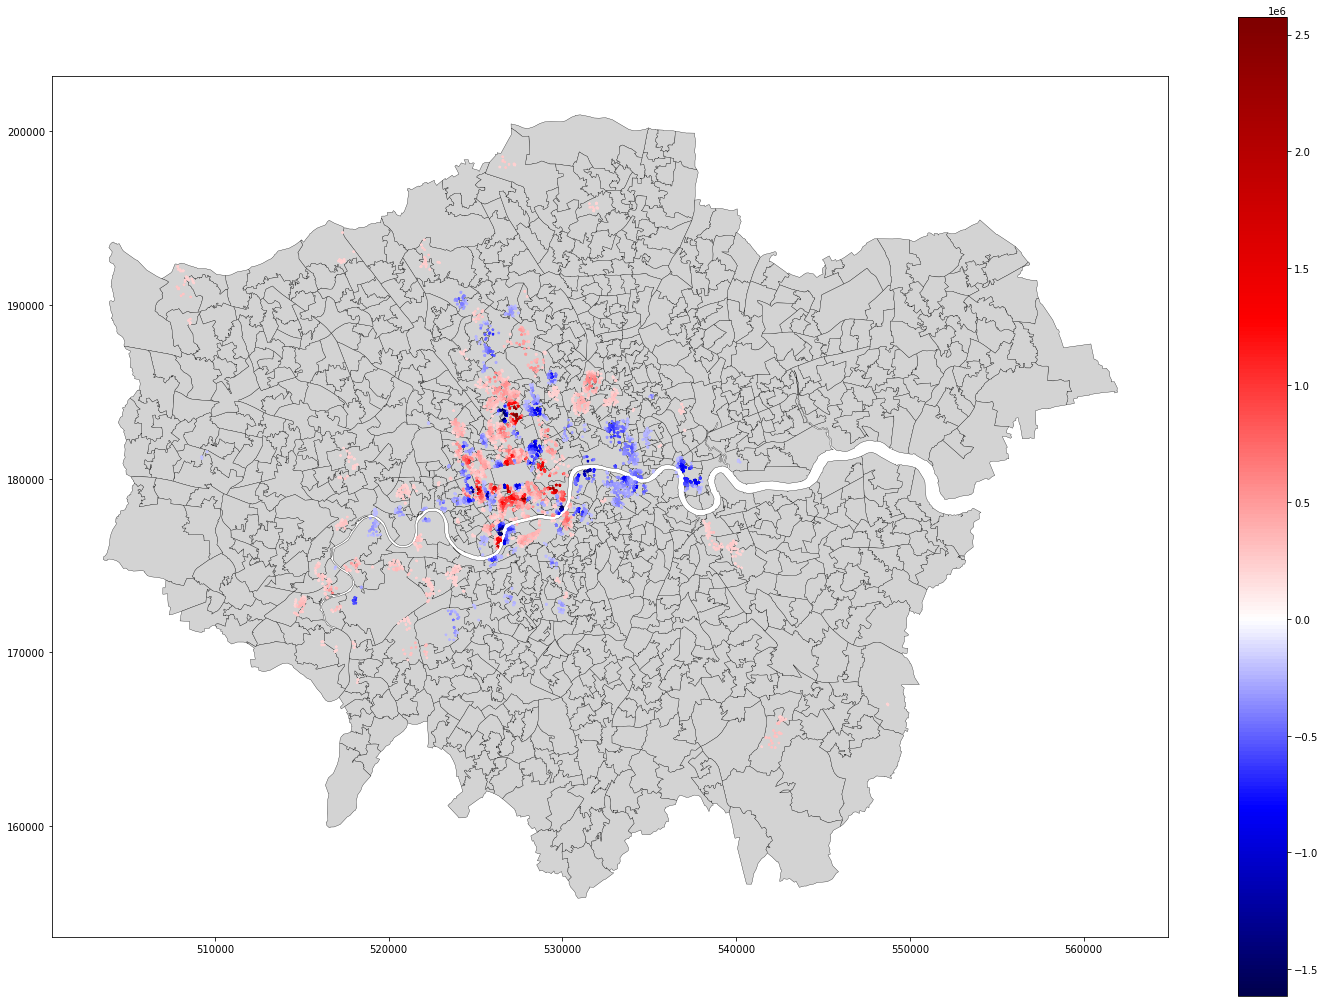

In [108]:
import matplotlib.pyplot as plt
f,ax = plt.subplots(figsize=(25,18))
cmap = plt.cm.seismic

vmin=georgia_data_geo_clu.sentiment_polarity.min()
vmax=georgia_data_geo_clu.sentiment_polarity.max()

# vmin1=ldn_msoas_mean.sentiment_polarity_mean.min()
# vmax1=ldn_msoas_mean.sentiment_polarity_mean.max()
cmap = shift_colormap(cmap,start=0.0, midpoint=1- vmax/(vmax + abs(vmin)))
# vmin=-vmax
sm = plt.cm.ScalarMappable(cmap=cmap,norm = plt . Normalize (vmin = vmin , vmax = vmax ))
sm1 = plt.cm.ScalarMappable(cmap=cmap,norm = plt . Normalize (vmin = -vmax , vmax = vmax ))
cmap=sm.cmap   
# sm1 = plt.cm.ScalarMappable(cmap=cmap,norm = plt . Normalize (vmin = vmin1 , vmax = vmax1 ))
# gdf[gdf['TCITY15NM']=='London'].plot(facecolor='none',ax=ax)
ldn_msoas.plot(facecolor='none',color='lightgrey',ax=ax,edgecolor='black',lw=0.3)
# georgia_shp_geo.plot(column='cof_apartment',cmap='viridis', legend=True, marker='*', markersize=1, ax=ax)
tmp2.plot( column='sentiment_polarity',marker='*', markersize=5,cmap=cmap,vmin=vmin,vmax=vmax, ax=ax)
# georgia_data_geo_clu[georgia_data_geo_clu['clu']==0].plot( column='sentiment_polarity',marker='s', markersize=20,cmap=cmap, 
#         vmin=vmin,vmax=vmax,ax=ax)
# borough.plot(facecolor='none',ax=ax,edgecolor='black', lw=0.6)
# georgia_data_geo_clu[georgia_data_geo_clu['clu']==0].plot( column='sentiment_polarity',marker='^',markersize=20,cmap=cmap, edgecolor='black',
#          vmin=vmin,vmax=vmax,ax=ax,lw=0.6)
# georgia_data_geo_clu[georgia_data_geo_clu['clu']==2].plot( column='sentiment_polarity',marker='s', markersize=20,cmap=cmap, edgecolor='black',
#           vmin=vmin,vmax=vmax,ax=ax,lw=0.6)
# georgia_data_geo_clu[georgia_data_geo_clu['clu']==5].plot( column='sentiment_polarity', markersize=20,cmap=cmap, edgecolor='black',
#           vmin=vmin,vmax=vmax,ax=ax,lw=0.6)
# georgia_data_geo_clu[georgia_data_geo_clu['clu']==12].plot( column='sentiment_polarity',marker='>', markersize=20,cmap=cmap, edgecolor='black',
#           vmin=vmin,vmax=vmax,ax=ax)

cbar = f.colorbar(sm)
# ax.set_xlim([520000,535000])
# ax.set_ylim([175000,186000])

rectan

In [95]:
from shapely import wkt #well known text   520000,535000  175000,186000
rect = 'POLYGON((520000 175000, 520000 186000, 535000 175000, 535000 186000))'
rectgeo = gpd.GeoDataFrame({'id':[0], 'coordinates':rect})
print(rectgeo)
rectgeo['geometry'] = rectgeo.coordinates.apply(wkt.loads)
rectgeo = rectgeo.set_crs('epsg:27700')
rectgeo.plot(edgecolor='red', facecolor='none')

IllegalArgumentException: Points of LinearRing do not form a closed linestring


   id                                        coordinates
0   0  POLYGON((520000 175000, 520000 186000, 535000 ...


WKTReadingError: Could not create geometry because of errors while reading input.

f1 新

In [146]:
georgia_data_geo_fi=pd.read_csv('london_gwr_pra_fil.csv')

In [147]:
georgia_data_geo_fi
georgia_data_geo_fi=gpd.GeoDataFrame(georgia_data_geo_fi[['sentiment_polarity','sentiment_subjectivity','lon','lat']],geometry=gpd.points_from_xy(georgia_data_geo_fi.lon, georgia_data_geo_fi.lat, crs='epsg:4326'))
georgia_data_geo_fi=georgia_data_geo_fi.to_crs("epsg:27700")


In [89]:
georgia_data_geo_fi.head()

sentiment_polarity  sentiment_subjectivity       lon        lat  \
0       -6.640877e+05           -3.640191e+06 -0.145511  51.518726   
1        1.221074e+06            1.578768e+06 -0.196769  51.498497   
2        6.865018e+05            3.129547e+06 -0.206414  51.496120   
3        5.494918e+05           -8.964651e+05 -0.197108  51.517040   
4        2.956036e+05            2.193703e+06 -0.257136  51.415540   

                        geometry  
0  POINT (528767.771 181608.297)  
1  POINT (525266.998 179269.867)  
2  POINT (524604.021 178989.087)  
3  POINT (525192.673 181331.351)  
4  POINT (521296.463 169943.200)

In [148]:
from sklearn.preprocessing import RobustScaler, MinMaxScaler
df_clu=georgia_data_geo_fi

rs = RobustScaler(quantile_range=(10.0, 90.0))
raw = df_clu[['lon','lat','sentiment_polarity']].copy()
normed = raw.copy()
for c in raw.columns.values:
    normed[c] = rs.fit_transform(raw[c].values.reshape(-1,1))
    print("The range of {} is [{}, {}]".format(c, normed[c].min(), normed[c].max()))
normed.head()
from sklearn.cluster import KMeans, DBSCAN
minPts = 5 # we set minPts as normed.shape[1] + 1 
epsilon = 0.1
dbsc = DBSCAN(eps=epsilon, min_samples=minPts)
dbsc.fit(normed)
cluster_nm = dbsc.labels_
df_clu['clu']=cluster_nm

The range of lon is [-2.2369892247104746, 2.250573292988035]
The range of lat is [-1.333446164714222, 1.3695031494672099]
The range of sentiment_polarity is [-1.2516540144465496, 1.2979952912199921]


In [126]:
pd.set_option('display.max_rows', None)
georgia_data_geo_clu=df_clu
georgia_data_geo_clu.groupby('clu').count().sort_values(['lon'],ascending=False).head(10)

sentiment_polarity  sentiment_subjectivity  lon  lat  geometry
clu                                                                
 1                  657                     657  657  657       657
 4                  161                     161  161  161       161
 0                  111                     111  111  111       111
 6                  101                     101  101  101       101
 9                   90                      90   90   90        90
 8                   85                      85   85   85        85
-1                   84                      84   84   84        84
 11                  62                      62   62   62        62
 15                  57                      57   57   57        57
 7                   51                      51   51   51        51

/opt/conda/envs/sds2021/lib/python3.9/site-packages/mgwr/utils.py:56: UserWarning: Trying to register the cmap 'shiftedcmap' which already exists.
  plt.register_cmap(cmap=new_cmap)


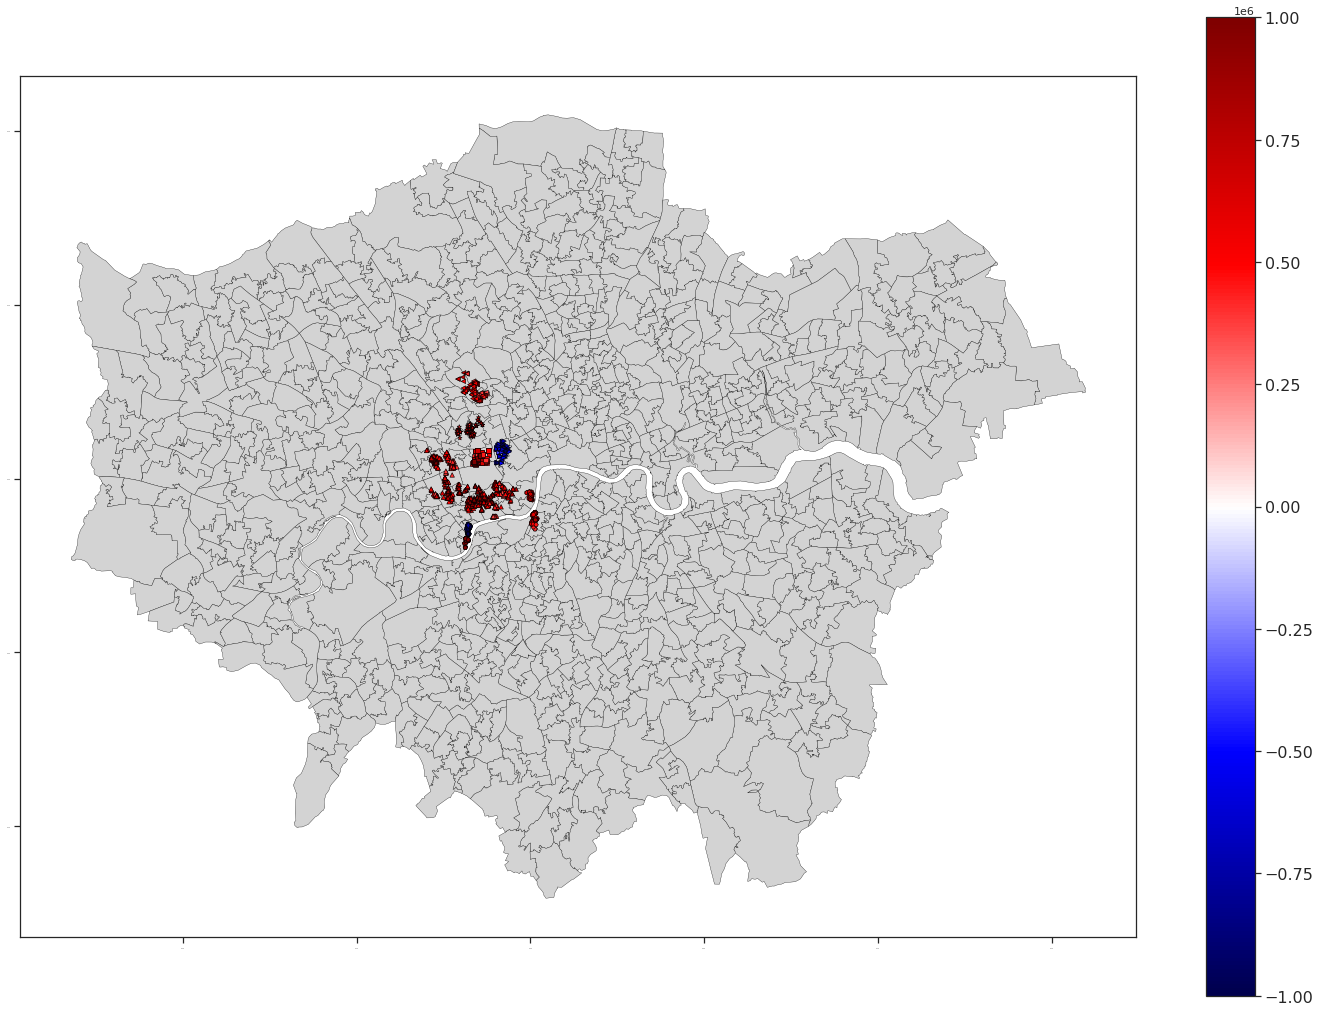

In [161]:
import matplotlib.pyplot as plt
f,ax = plt.subplots(figsize=(25,18))
cmap = plt.cm.seismic
vmin=-1000000
vmax=1000000
# vmin=georgia_data_geo_clu.sentiment_polarity.min()
# vmax=georgia_data_geo_clu.sentiment_polarity.max()

# vmin1=ldn_msoas_mean.sentiment_polarity_mean.min()
# vmax1=ldn_msoas_mean.sentiment_polarity_mean.max()
cmap = shift_colormap(cmap,start=0.0, midpoint=1- vmax/(vmax + abs(vmin)))
# vmin=-vmax
sm = plt.cm.ScalarMappable(cmap=cmap,norm = plt . Normalize (vmin = vmin , vmax = vmax ))
sm1 = plt.cm.ScalarMappable(cmap=cmap,norm = plt . Normalize (vmin = -vmax , vmax = vmax ))
cmap=sm.cmap   
# sm1 = plt.cm.ScalarMappable(cmap=cmap,norm = plt . Normalize (vmin = vmin1 , vmax = vmax1 ))
# gdf[gdf['TCITY15NM']=='London'].plot(facecolor='none',ax=ax)
ldn_msoas.plot(facecolor='none',color='lightgrey',ax=ax,edgecolor='black',lw=0.3)
# georgia_shp_geo.plot(column='cof_apartment',cmap='viridis', legend=True, marker='*', markersize=1, ax=ax)
# tmp2.plot( column='sentiment_polarity',marker='*', markersize=5,cmap=cmap,vmin=vmin,vmax=vmax, ax=ax)
# georgia_data_geo_clu[georgia_data_geo_clu['clu']==0].plot( column='sentiment_polarity',marker='s', markersize=20,cmap=cmap, 
#         vmin=vmin,vmax=vmax,ax=ax)
# borough.plot(facecolor='none',ax=ax,edgecolor='black', lw=0.6)
georgia_data_geo_clu[georgia_data_geo_clu['clu']==1].plot( column='sentiment_polarity',marker='^',markersize=20,cmap=cmap, edgecolor='black',
         vmin=vmin,vmax=vmax,ax=ax,lw=0.6)
georgia_data_geo_clu[georgia_data_geo_clu['clu']==4].plot( column='sentiment_polarity',marker='s',markersize=20,cmap=cmap, edgecolor='black',
         vmin=vmin,vmax=vmax,ax=ax,lw=0.6)
georgia_data_geo_clu[georgia_data_geo_clu['clu']==0].plot( column='sentiment_polarity',marker='>',markersize=20,cmap=cmap, edgecolor='black',
         vmin=vmin,vmax=vmax,ax=ax,lw=0.6)
georgia_data_geo_clu[georgia_data_geo_clu['clu']==6].plot( column='sentiment_polarity',marker='<',markersize=20,cmap=cmap, edgecolor='black',
         vmin=vmin,vmax=vmax,ax=ax,lw=0.6)
georgia_data_geo_clu[georgia_data_geo_clu['clu']==9].plot( column='sentiment_polarity',marker='*',markersize=20,cmap=cmap, edgecolor='black',
         vmin=vmin,vmax=vmax,ax=ax,lw=0.6)
georgia_data_geo_clu[georgia_data_geo_clu['clu']==8].plot( column='sentiment_polarity',marker='H',markersize=20,cmap=cmap, edgecolor='black',
         vmin=vmin,vmax=vmax,ax=ax,lw=0.6)
georgia_data_geo_clu[georgia_data_geo_clu['clu']==11].plot( column='sentiment_polarity',marker='d',markersize=20,cmap=cmap, edgecolor='black',
         vmin=vmin,vmax=vmax,ax=ax,lw=0.6)
georgia_data_geo_clu[georgia_data_geo_clu['clu']==15].plot( column='sentiment_polarity',marker='p',markersize=20,cmap=cmap, edgecolor='black',
         vmin=vmin,vmax=vmax,ax=ax,lw=0.6)
georgia_data_geo_clu[georgia_data_geo_clu['clu']==7].plot( column='sentiment_polarity',marker='h',markersize=20,cmap=cmap, edgecolor='black',
         vmin=vmin,vmax=vmax,ax=ax,lw=0.6)
cbar = f.colorbar(sm)

cbar.ax.tick_params(labelsize=16)
plt.xticks(fontsize=0)
plt.yticks(fontsize=0)
plt.savefig('po2.png')
# ax.set_xlim([520000,535000])
# ax.set_ylim([175000,186000])

/opt/conda/envs/sds2021/lib/python3.9/site-packages/mgwr/utils.py:56: UserWarning: Trying to register the cmap 'shiftedcmap' which already exists.
  plt.register_cmap(cmap=new_cmap)


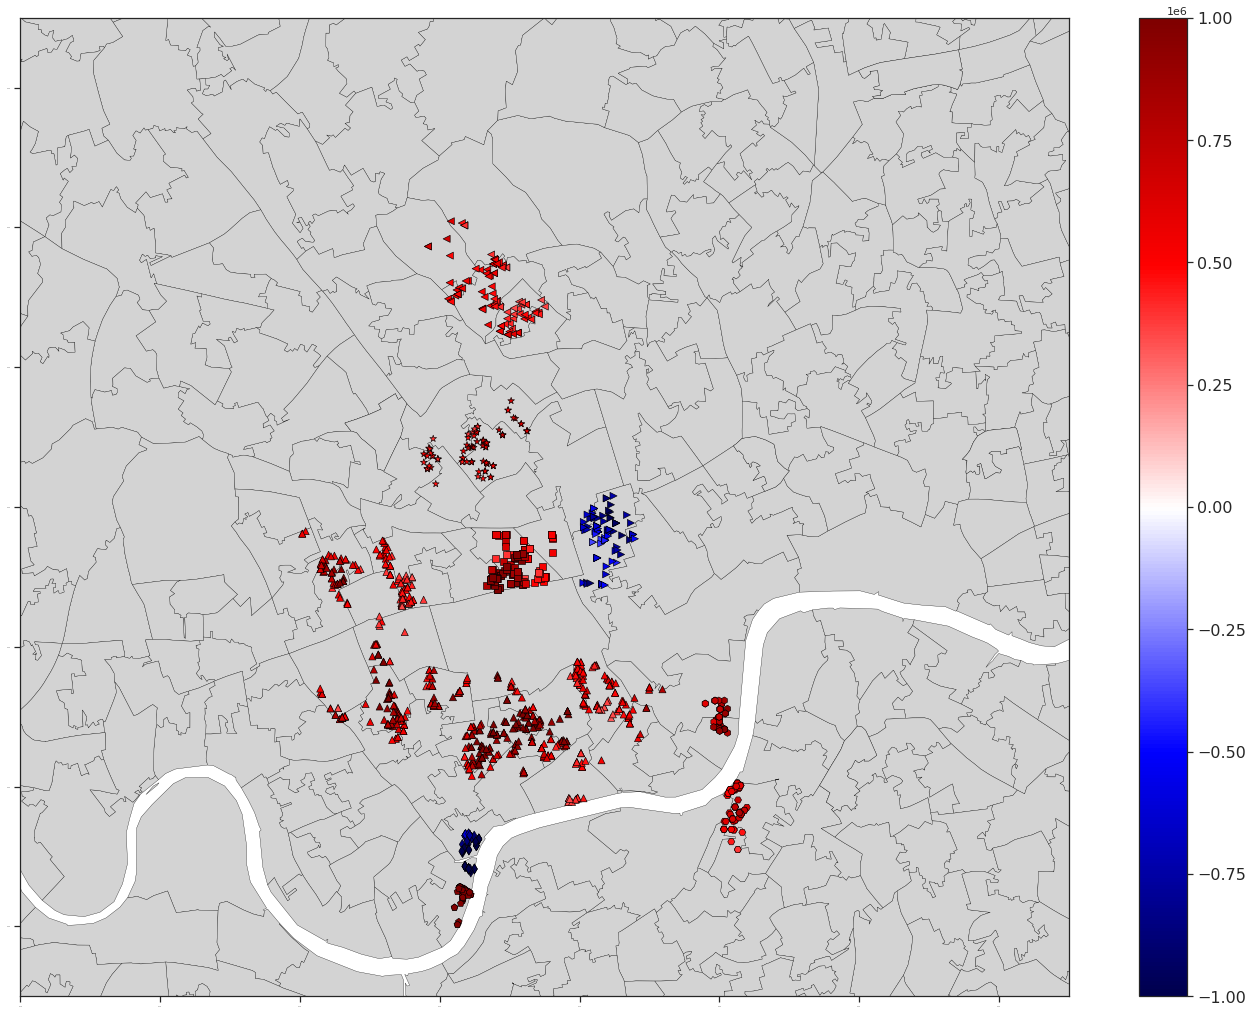

In [162]:
import matplotlib.pyplot as plt
f,ax = plt.subplots(figsize=(25,18))
cmap = plt.cm.seismic
vmin=-1000000
vmax=1000000
# vmin=georgia_data_geo_clu.sentiment_polarity.min()
# vmax=georgia_data_geo_clu.sentiment_polarity.max()

# vmin1=ldn_msoas_mean.sentiment_polarity_mean.min()
# vmax1=ldn_msoas_mean.sentiment_polarity_mean.max()
cmap = shift_colormap(cmap,start=0.0, midpoint=1- vmax/(vmax + abs(vmin)))
# vmin=-vmax
sm = plt.cm.ScalarMappable(cmap=cmap,norm = plt . Normalize (vmin = vmin , vmax = vmax ))
sm1 = plt.cm.ScalarMappable(cmap=cmap,norm = plt . Normalize (vmin = -vmax , vmax = vmax ))
cmap=sm.cmap   
# sm1 = plt.cm.ScalarMappable(cmap=cmap,norm = plt . Normalize (vmin = vmin1 , vmax = vmax1 ))
# gdf[gdf['TCITY15NM']=='London'].plot(facecolor='none',ax=ax)
ldn_msoas.plot(facecolor='none',color='lightgrey',ax=ax,edgecolor='black',lw=0.3)
# georgia_shp_geo.plot(column='cof_apartment',cmap='viridis', legend=True, marker='*', markersize=1, ax=ax)
# tmp2.plot( column='sentiment_polarity',marker='*', markersize=5,cmap=cmap,vmin=vmin,vmax=vmax, ax=ax)
# georgia_data_geo_clu[georgia_data_geo_clu['clu']==0].plot( column='sentiment_polarity',marker='s', markersize=20,cmap=cmap, 
#         vmin=vmin,vmax=vmax,ax=ax)
# borough.plot(facecolor='none',ax=ax,edgecolor='black', lw=0.6)
georgia_data_geo_clu[georgia_data_geo_clu['clu']==1].plot( column='sentiment_polarity',marker='^',markersize=50,cmap=cmap, edgecolor='black',
         vmin=vmin,vmax=vmax,ax=ax,lw=0.6)
georgia_data_geo_clu[georgia_data_geo_clu['clu']==4].plot( column='sentiment_polarity',marker='s',markersize=50,cmap=cmap, edgecolor='black',
         vmin=vmin,vmax=vmax,ax=ax,lw=0.6)
georgia_data_geo_clu[georgia_data_geo_clu['clu']==0].plot( column='sentiment_polarity',marker='>',markersize=50,cmap=cmap, edgecolor='black',
         vmin=vmin,vmax=vmax,ax=ax,lw=0.6)
georgia_data_geo_clu[georgia_data_geo_clu['clu']==6].plot( column='sentiment_polarity',marker='<',markersize=50,cmap=cmap, edgecolor='black',
         vmin=vmin,vmax=vmax,ax=ax,lw=0.6)
georgia_data_geo_clu[georgia_data_geo_clu['clu']==9].plot( column='sentiment_polarity',marker='*',markersize=50,cmap=cmap, edgecolor='black',
         vmin=vmin,vmax=vmax,ax=ax,lw=0.6)
georgia_data_geo_clu[georgia_data_geo_clu['clu']==8].plot( column='sentiment_polarity',marker='H',markersize=50,cmap=cmap, edgecolor='black',
         vmin=vmin,vmax=vmax,ax=ax,lw=0.6)
georgia_data_geo_clu[georgia_data_geo_clu['clu']==11].plot( column='sentiment_polarity',marker='d',markersize=50,cmap=cmap, edgecolor='black',
         vmin=vmin,vmax=vmax,ax=ax,lw=0.6)
georgia_data_geo_clu[georgia_data_geo_clu['clu']==15].plot( column='sentiment_polarity',marker='p',markersize=50,cmap=cmap, edgecolor='black',
         vmin=vmin,vmax=vmax,ax=ax,lw=0.6)
georgia_data_geo_clu[georgia_data_geo_clu['clu']==7].plot( column='sentiment_polarity',marker='h',markersize=50,cmap=cmap, edgecolor='black',
         vmin=vmin,vmax=vmax,ax=ax,lw=0.6)
cbar = f.colorbar(sm)
cbar.ax.tick_params(labelsize=16)
plt.xticks(fontsize=0)
plt.yticks(fontsize=0)
ax.set_xlim([520000,535000])
ax.set_ylim([175000,189000])
plt.savefig('po3.png')

tmp2

In [168]:
from sklearn.preprocessing import RobustScaler, MinMaxScaler
df_clu=tmp2

rs = RobustScaler(quantile_range=(10.0, 90.0))
raw = df_clu[['lon','lat','sentiment_subjectivity']].copy()
normed = raw.copy()
for c in raw.columns.values:
    normed[c] = rs.fit_transform(raw[c].values.reshape(-1,1))
    print("The range of {} is [{}, {}]".format(c, normed[c].min(), normed[c].max()))
normed.head()
from sklearn.cluster import KMeans, DBSCAN
minPts = 5 # we set minPts as normed.shape[1] + 1 
epsilon = 0.1
dbsc = DBSCAN(eps=epsilon, min_samples=minPts)
dbsc.fit(normed)
cluster_nm = dbsc.labels_
df_clu['clu']=cluster_nm

The range of lon is [-1.3939263348034594, 0.9123426339388052]
The range of lat is [-2.104970361986656, 2.18963213054805]
The range of sentiment_subjectivity is [-3.8960976529203992, 1.5172892470954138]


In [169]:
pd.set_option('display.max_rows', None)
georgia_data_geo_clu=df_clu
georgia_data_geo_clu.groupby('clu').count().sort_values(['lon'],ascending=False).head(10)

sentiment_polarity  sentiment_subjectivity  geometry  lon  lat
clu                                                                
 20                 760                     760       760  760  760
 0                  159                     159       159  159  159
-1                  105                     105       105  105  105
 22                  94                      94        94   94   94
 4                   87                      87        87   87   87
 28                  55                      55        55   55   55
 31                  49                      49        49   49   49
 25                  49                      49        49   49   49
 33                  48                      48        48   48   48
 24                  47                      47        47   47   47

In [115]:
pd.set_option('display.max_rows', None)
georgia_data_geo_clu=df_clu
georgia_data_geo_clu.groupby('clu').count().sort_values(['lon'],ascending=False).head(10)

sentiment_polarity  sentiment_subjectivity  geometry  lon  lat
clu                                                                
 20                 760                     760       760  760  760
 0                  159                     159       159  159  159
-1                  105                     105       105  105  105
 22                  94                      94        94   94   94
 4                   87                      87        87   87   87
 28                  55                      55        55   55   55
 31                  49                      49        49   49   49
 25                  49                      49        49   49   49
 33                  48                      48        48   48   48
 24                  47                      47        47   47   47

/opt/conda/envs/sds2021/lib/python3.9/site-packages/mgwr/utils.py:56: UserWarning: Trying to register the cmap 'shiftedcmap' which already exists.
  plt.register_cmap(cmap=new_cmap)


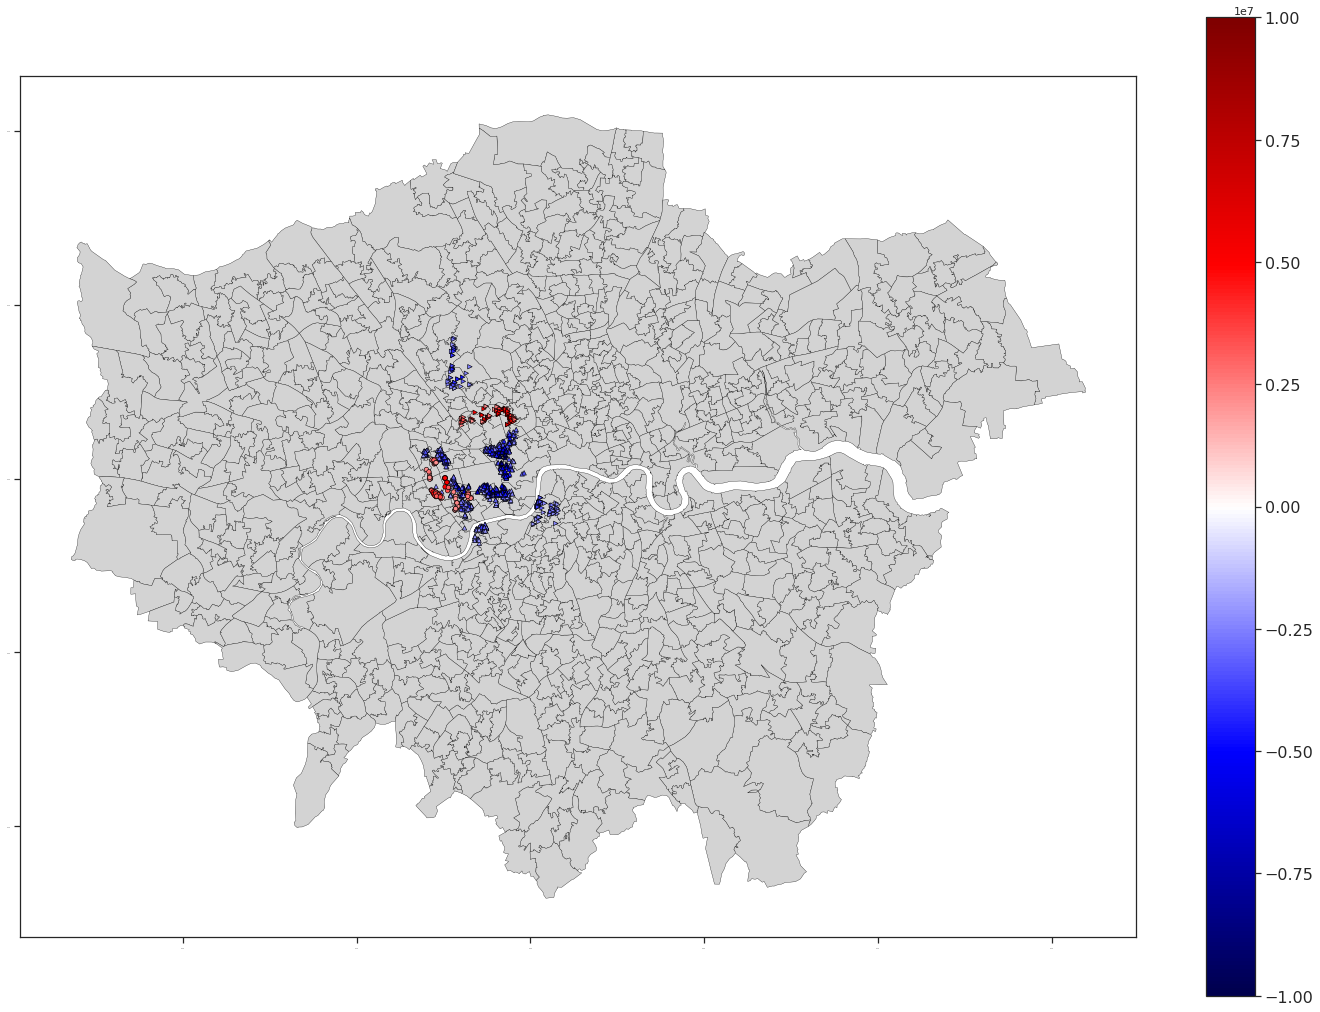

In [170]:
import matplotlib.pyplot as plt
f,ax = plt.subplots(figsize=(25,18))
cmap = plt.cm.seismic

vmin=-10000000
vmax=10000000

# vmin1=ldn_msoas_mean.sentiment_polarity_mean.min()
# vmax1=ldn_msoas_mean.sentiment_polarity_mean.max()
cmap = shift_colormap(cmap,start=0.0, midpoint=1- vmax/(vmax + abs(vmin)))
# vmin=-vmax
sm = plt.cm.ScalarMappable(cmap=cmap,norm = plt . Normalize (vmin = vmin , vmax = vmax ))
sm1 = plt.cm.ScalarMappable(cmap=cmap,norm = plt . Normalize (vmin = -vmax , vmax = vmax ))
cmap=sm.cmap   
# sm1 = plt.cm.ScalarMappable(cmap=cmap,norm = plt . Normalize (vmin = vmin1 , vmax = vmax1 ))
# gdf[gdf['TCITY15NM']=='London'].plot(facecolor='none',ax=ax)
ldn_msoas.plot(facecolor='none',color='lightgrey',ax=ax,edgecolor='black',lw=0.3)
# georgia_shp_geo.plot(column='cof_apartment',cmap='viridis', legend=True, marker='*', markersize=1, ax=ax)
# tmp2.plot( column='sentiment_polarity',marker='*', markersize=5,cmap=cmap,vmin=vmin,vmax=vmax, ax=ax)
# georgia_data_geo_clu[georgia_data_geo_clu['clu']==0].plot( column='sentiment_polarity',marker='s', markersize=20,cmap=cmap, 
#         vmin=vmin,vmax=vmax,ax=ax)
# borough.plot(facecolor='none',ax=ax,edgecolor='black', lw=0.6)
georgia_data_geo_clu[georgia_data_geo_clu['clu']==20].plot( column='sentiment_subjectivity',marker='^',markersize=20,cmap=cmap, edgecolor='black',
         vmin=vmin,vmax=vmax,ax=ax,lw=0.6)
# georgia_data_geo_clu[georgia_data_geo_clu['clu']==15].plot( column='sentiment_polarity',marker='s', markersize=20,cmap=cmap, edgecolor='black',
#           vmin=vmin,vmax=vmax,ax=ax,lw=0.6)
georgia_data_geo_clu[georgia_data_geo_clu['clu']==0].plot( column='sentiment_subjectivity', markersize=20,cmap=cmap, edgecolor='black',
          vmin=vmin,vmax=vmax,ax=ax,lw=0.6)
georgia_data_geo_clu[georgia_data_geo_clu['clu']==22].plot( column='sentiment_subjectivity',marker='>', markersize=20,cmap=cmap, edgecolor='black',
          vmin=vmin,vmax=vmax,ax=ax,lw=0.6)
georgia_data_geo_clu[georgia_data_geo_clu['clu']==4].plot( column='sentiment_subjectivity',marker='>', markersize=20,cmap=cmap, edgecolor='black',
          vmin=vmin,vmax=vmax,ax=ax,lw=0.6)
georgia_data_geo_clu[georgia_data_geo_clu['clu']==28].plot( column='sentiment_subjectivity',marker='>', markersize=20,cmap=cmap, edgecolor='black',
          vmin=vmin,vmax=vmax,ax=ax,lw=0.6)


cbar = f.colorbar(sm)
cbar.ax.tick_params(labelsize=16)
plt.xticks(fontsize=0)
plt.yticks(fontsize=0)
plt.savefig('sub2.png')
# ax.set_xlim([520000,535000])
# ax.set_ylim([175000,186000])

/opt/conda/envs/sds2021/lib/python3.9/site-packages/mgwr/utils.py:56: UserWarning: Trying to register the cmap 'shiftedcmap' which already exists.
  plt.register_cmap(cmap=new_cmap)


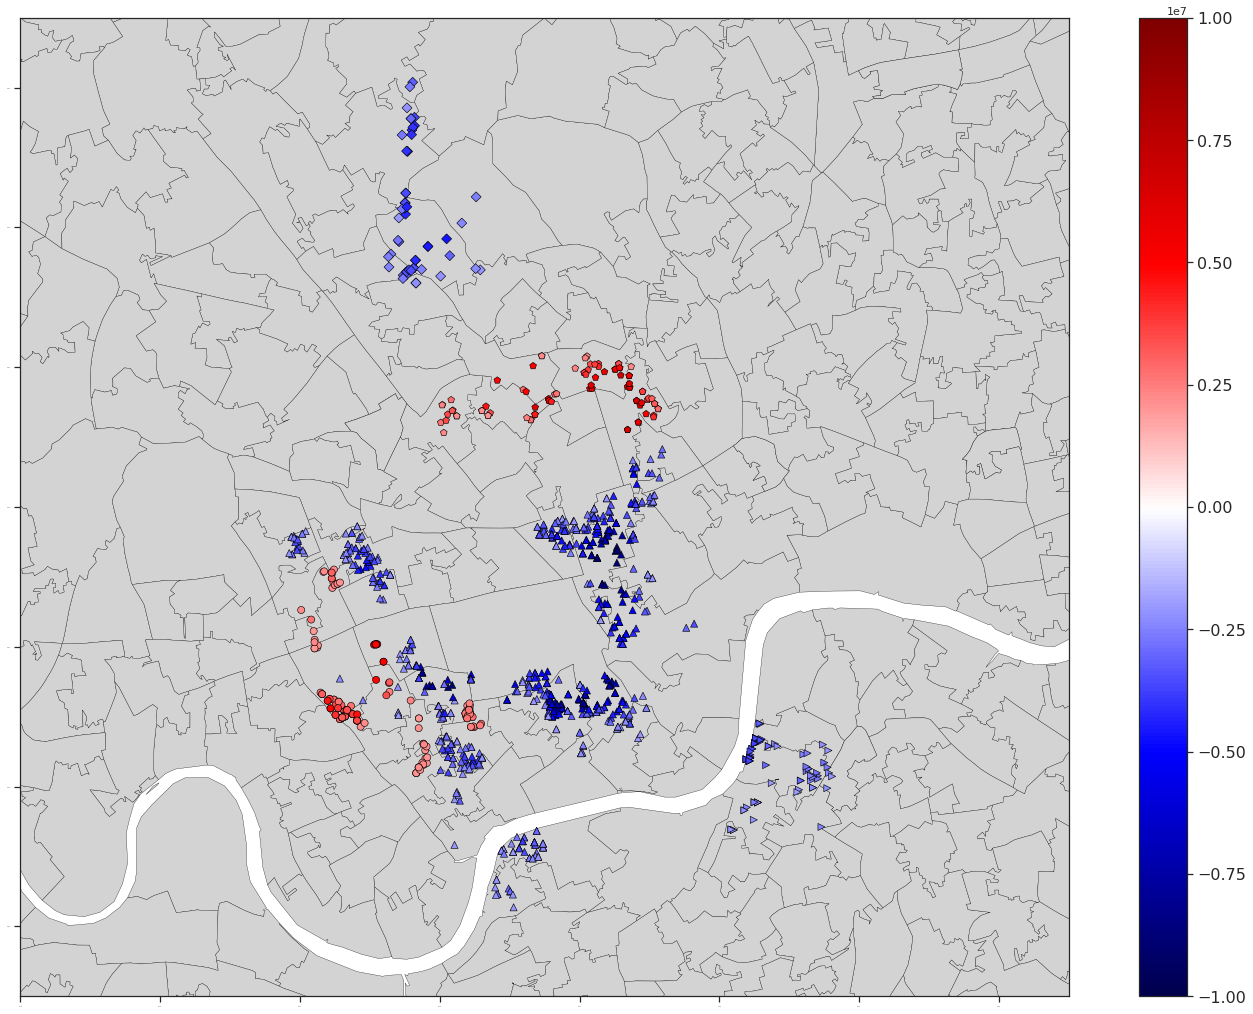

In [171]:
import matplotlib.pyplot as plt
f,ax = plt.subplots(figsize=(25,18))
cmap = plt.cm.seismic

vmin=-10000000
vmax=10000000

# vmin1=ldn_msoas_mean.sentiment_polarity_mean.min()
# vmax1=ldn_msoas_mean.sentiment_polarity_mean.max()
cmap = shift_colormap(cmap,start=0.0, midpoint=1- vmax/(vmax + abs(vmin)))
# vmin=-vmax
sm = plt.cm.ScalarMappable(cmap=cmap,norm = plt . Normalize (vmin = vmin , vmax = vmax ))
sm1 = plt.cm.ScalarMappable(cmap=cmap,norm = plt . Normalize (vmin = -vmax , vmax = vmax ))
cmap=sm.cmap   
# sm1 = plt.cm.ScalarMappable(cmap=cmap,norm = plt . Normalize (vmin = vmin1 , vmax = vmax1 ))
# gdf[gdf['TCITY15NM']=='London'].plot(facecolor='none',ax=ax)
ldn_msoas.plot(facecolor='none',color='lightgrey',ax=ax,edgecolor='black',lw=0.3)
# georgia_shp_geo.plot(column='cof_apartment',cmap='viridis', legend=True, marker='*', markersize=1, ax=ax)
# tmp2.plot( column='sentiment_polarity',marker='*', markersize=5,cmap=cmap,vmin=vmin,vmax=vmax, ax=ax)
# georgia_data_geo_clu[georgia_data_geo_clu['clu']==0].plot( column='sentiment_polarity',marker='s', markersize=20,cmap=cmap, 
#         vmin=vmin,vmax=vmax,ax=ax)
# borough.plot(facecolor='none',ax=ax,edgecolor='black', lw=0.6)
georgia_data_geo_clu[georgia_data_geo_clu['clu']==20].plot( column='sentiment_subjectivity',marker='^',markersize=50,cmap=cmap, edgecolor='black',
         vmin=vmin,vmax=vmax,ax=ax,lw=0.6)
# georgia_data_geo_clu[georgia_data_geo_clu['clu']==15].plot( column='sentiment_polarity',marker='s', markersize=20,cmap=cmap, edgecolor='black',
#           vmin=vmin,vmax=vmax,ax=ax,lw=0.6)
georgia_data_geo_clu[georgia_data_geo_clu['clu']==0].plot( column='sentiment_subjectivity', markersize=50,cmap=cmap, edgecolor='black',
          vmin=vmin,vmax=vmax,ax=ax,lw=0.6)
georgia_data_geo_clu[georgia_data_geo_clu['clu']==22].plot( column='sentiment_subjectivity',marker='>', markersize=50,cmap=cmap, edgecolor='black',
          vmin=vmin,vmax=vmax,ax=ax,lw=0.6)
georgia_data_geo_clu[georgia_data_geo_clu['clu']==4].plot( column='sentiment_subjectivity',marker='p', markersize=50,cmap=cmap, edgecolor='black',
          vmin=vmin,vmax=vmax,ax=ax,lw=0.6)
georgia_data_geo_clu[georgia_data_geo_clu['clu']==28].plot( column='sentiment_subjectivity',marker='D', markersize=50,cmap=cmap, edgecolor='black',
          vmin=vmin,vmax=vmax,ax=ax,lw=0.6)

cbar = f.colorbar(sm)

ax.set_xlim([520000,535000])
ax.set_ylim([175000,189000])
cbar.ax.tick_params(labelsize=16)
plt.xticks(fontsize=0)
plt.yticks(fontsize=0)
plt.savefig('sub3.png')